In [134]:
import torch
import pyro
import pyro.distributions as dist
from torch.distributions import constraints
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pyro.set_rng_seed(101)
torch.manual_seed(101)
torch.set_printoptions(precision=3)
%matplotlib inline

#https://github.com/pyro-ppl/pyro/blob/dev/examples/contrib/timeseries/gp_models.py

## Introduction

In the previous post we introduced pyro and its building blocks such as schotastic function, primitive sample and param primitive statement, model and guide and define pyro model and use it to generate data, learn from data and predict future observations.

In this section, we will learn about automatic inference in Pyro, and how to use Pyro primitives and the effect handling library (pyro.poutine) to build custom tools for analysis.

### Problem Domain
We are provided with a smart-meter power consumption dataset

In [75]:
data = pd.read_csv("../data/data.csv", index_col=0)
data['Time'] = pd.to_datetime(data.index.values, utc=True)

In [76]:
data.index = data["Time"]
data = data.drop(["Time"],axis=1)

In [77]:
data.head()

,fridge freezer,washer dryer,dish washer,television,kettle,microwave,mains
Time,,,,,,,
2015-01-03 00:00:00+00:00,83.500000,0.0,1.0,1.000,1.0,1.0,258.10483
2015-01-03 00:01:00+00:00,85.375000,0.0,1.0,0.875,1.0,1.0,260.05566
2015-01-03 00:02:00+00:00,86.666664,0.0,1.0,1.000,1.0,1.0,261.23950
2015-01-03 00:03:00+00:00,86.750000,0.0,1.0,1.000,1.0,1.0,261.21918
2015-01-03 00:04:00+00:00,86.250000,0.0,1.0,1.000,1.0,1.0,260.97733


In [78]:
agg = data.mains
agg.head()

Time
2015-01-03 00:00:00+00:00    258.10483
2015-01-03 00:01:00+00:00    260.05566
2015-01-03 00:02:00+00:00    261.23950
2015-01-03 00:03:00+00:00    261.21918
2015-01-03 00:04:00+00:00    260.97733
Name: mains, dtype: float64

In [79]:
agg_h=agg.rolling(24*1).median()

/home/sambaiga/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


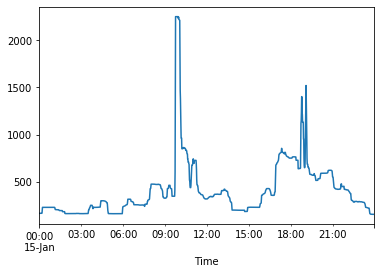

In [80]:
agg_h["2015-01-15"].plot()

### Task: Build a bayesian model for time series forecasting and infer latent parameters
First let incorparate global trend and seasonality in the model

$$
\begin{align*}
log(p_i) &\sim \mathcal{N}(\mu_i, \sigma)\\
\mu_i &= slope\ .\ t_i + intercept \\
\end{align*}
$$


In [8]:
def model_global_trend(p):
    slope = pyro.param('slope', torch.tensor(0.))
    sigma = pyro.param('sigma', torch.tensor(1.0), constraints=dist.constraints.positive)
    intercept = pyro.param('intercept', torch.tensor(13.))
    for i in range(len(y)):
        log_p_hat = slope * i + intercept
        pyro.sample('y_{}'.format(i), dist.LogNormal(log_p_hat, sigma), obs=p[i])

From the global trend model above , pyro.param designate model parameters that we would like to optimize. Observations are denoted by the obs= keyword argument to pyro.sample. This specifies the likelihood function. Instead of log transforming the data, we use a LogNormal distribution. 

For global_trend model the observations are conditionally independent given the latent random variable slope and intercept. To explicitly mark this in Pyro use **plate** statement to construct for conditionally independent sequences of variables.

```python
with pyro.plate("name", size, subsample_size, device) as ind:
    # ...do conditionally independent stuff with ind...
```
However compared to ``range()`` each invocation of **plate** requires the user to provide a unique name.

**plate** can be used either sequentially as a generator or in parallel as a context manager. Sequential plate is similar to ``range()`` in that it generates a sequence of values. 
```python
 # This version declares sequential independence and subsamples data:
    for i in plate('data', 100, subsample_size=10):
         if z[i]:  # Control flow in this example prevents vectorization.
                obs = sample('obs_{}'.format(i), dist.Normal(loc, scale), obs=data[i])
```
Vectorized plate is similar to ``torch.arange()`` in that it yields an array of indices by which other tensors can be indexed. However, unlike  ``torch.arange()`` **plate**  also informs inference algorithms that the variables being indexed are conditionally independent.
```python
     # This version declares vectorized independence:
     with plate('data'):
            obs = sample('obs', dist.Normal(loc, scale), obs=data)
```

Additionally, plate can take advantage of the conditional independence assumptions by subsampling the indices and informing inference algorithms to scale various computed values. This is typically used to subsample minibatches of data:
```python
with plate("data", len(data), subsample_size=100) as ind:
    batch = data[ind]
    assert len(batch) == 100
```

We can therofore vectorize our global trend model

In [81]:
import pyro.contrib.timeseries as TS
torch.manual_seed(11)

In [82]:
data = agg_h.dropna()
time = data.index.values

data = data.values[:,None]
T, obs_dim = data.shape
T_forecast = 5000
T_train = T - T_forecast


data_mean = data[0:T_train, :].mean(0)
data -= data_mean
data_std = data[0:T_train, :].std(0)
data /= data_std

data = torch.tensor(data).double()

init_learning_rate=0.01
final_learning_rate=0.0001
beta1=0.5
epochs=500

In [84]:
model = TS.DependentMaternGP(nu=1.5, obs_dim=obs_dim,
                                 length_scale_init=1.5 * torch.ones(obs_dim)).double()

adam = torch.optim.Adam(model.parameters(), lr=0.01,
                            betas=(beta1, 0.999), amsgrad=True)
    # we decay the learning rate over the course of training
gamma = (final_learning_rate / init_learning_rate) ** (1.0 / epochs)
scheduler = torch.optim.lr_scheduler.ExponentialLR(adam, gamma=gamma)
report_frequency=50

In [85]:
# training loop
for step in range(epochs):
    loss = -model.log_prob(data[0:T_train, :]).sum() / T_train
    loss.backward()
    adam.step()
    scheduler.step()

    if step % report_frequency == 0 or step == epochs - 1:
        print("[step %03d]  loss: %.3f" % (step, loss.item()))

[step 000]  loss: 0.480
[step 050]  loss: -0.082
[step 100]  loss: -0.418
[step 150]  loss: -0.588
[step 200]  loss: -0.671
[step 250]  loss: -0.713
[step 300]  loss: -0.734
[step 350]  loss: -0.746
[step 400]  loss: -0.752
[step 450]  loss: -0.756
[step 499]  loss: -0.758


## Prediction

In [148]:
import tqdm
from tqdm import tqdm_notebook as tqdm

In [150]:
T_multistep = 4000
T_onestep = T_forecast - T_multistep
onestep_means, onestep_stds = np.zeros((T_onestep, obs_dim)), np.zeros((T_onestep, obs_dim))
for t in range(T_onestep):
    
    if t==1:break
        
    print(data[0:T_train + t, :].shape)
    print(data[0:T_train, :].shape)
    
    prev_data = data[T_train-T_multistep:T_train, :]
    
    dts = torch.tensor([1.0]).double()
    pred_dist = model.forecast(data[0:T_train + t, :], dts)
    onestep_means[t, :] = pred_dist.loc.data.numpy()
    onestep_stds[t, :] = pred_dist.covariance_matrix.diagonal(dim1=-1, dim2=-2).data.numpy()

    

torch.Size([111557, 1])
torch.Size([111557, 1])


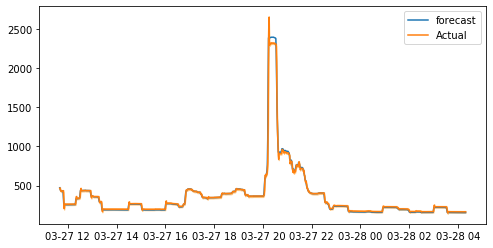

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
p90=(onestep_means[:,0] - 1.645 * onestep_stds[:,0])*data_std + data_mean
p10=(onestep_means[:,0] + 1.645 * onestep_stds[:,0])*data_std + data_mean
plt.plot(time[T_train:T_train+T_onestep], data[T_train:T_train+T_onestep].numpy()*data_std + data_mean, label='forecast')
plt.plot(time[T_train:T_train+T_onestep],onestep_means*data_std + data_mean, label='Actual')
plt.fill_between(time[T_train:T_train+T_onestep], p10, p90, alpha=0.4, 
                 color='darkorange')
plt.legend()

In [144]:
T_multistep=1000
dts = torch.arange(T_multistep).double()
pred_dist = model.forecast(data[:T_train+T_multistep, :], dts)

RuntimeError: cholesky_cpu: For batch 0: U(1,1) is zero, singular U.

In [141]:
pred_dist

MultivariateNormal(loc: torch.Size([1000, 1]), covariance_matrix: torch.Size([1000, 1, 1]))

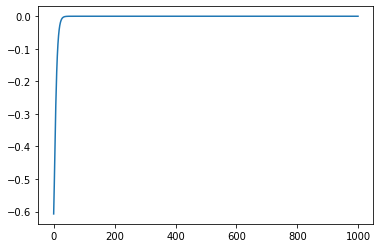

In [143]:
plt.plot(pred_dist.loc.data.numpy())